# Network 3 $\textit{E. Coli}$ Transcription Network with neural units' dynamics
Network topology is that of E Coli transcription network from Gao et al; neural network's dynamics is applied.

## Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
import numpy as np
from tqdm import tqdm
import math

## Creating the network

In [2]:
# Loading the adjecency matrix, network's topology
A = sio.loadmat('./TECB.mat')['A']*2
A.shape

(1550, 1550)

In [3]:
# parameters for the dynamics
s = .4
g = .4

In [4]:
def get_LCC(A, cutoff=2):
    ''' 
    Returns network 'A' with only it's strongly connected components that have number of nodes more than the 'cutoff'
    '''
    G = nx.from_numpy_matrix(A,
        create_using=nx.DiGraph
    )
    
    large_c_idx = []
    for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True):
        if len(c)>=cutoff:
            large_c_idx+= c

    A_rows = A[large_c_idx]
    A_largec = A_rows[:,large_c_idx]

    return A_largec
    

## Running the Dynamics

In [5]:
def neural_network_ODE(values, t, J, s=0.4, g=0.4):
    ''' 
    Neural units' dynamics
    -----------
    Returns rate values
    '''

    dvalues_dt = -values + s*np.tanh(values) + g*np.dot(J,np.tanh(values))

    return dvalues_dt

In [6]:
n_nodes = A.shape[0]
initial_values = np.ones(n_nodes) * 2
print(initial_values.shape)
t = np.arange(0, 20, 0.01)

# Solving ODEs
values = odeint(neural_network_ODE, initial_values, t, args=(A,s,g))

print(values.shape)


(1550,)
(2000, 1550)


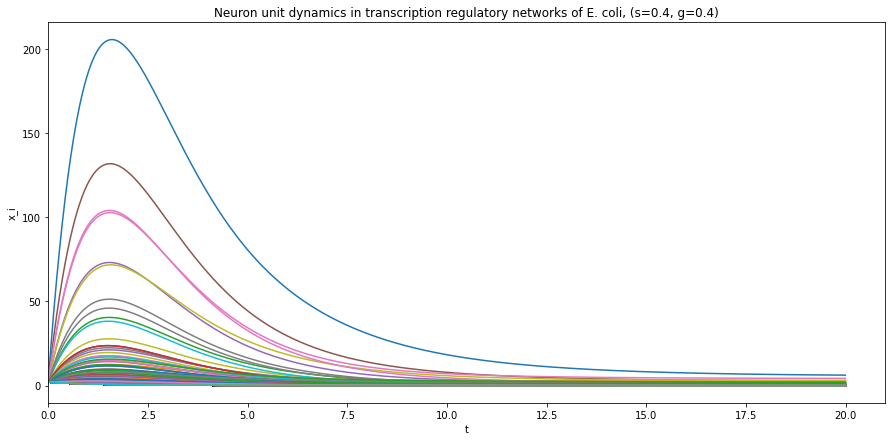

In [7]:
plt.figure(figsize=(15,7))

plt.plot(t, values)
plt.xlim(xmin=0)
plt.xlabel('t')
plt.ylabel('x_i')

plt.title(f'Neuron unit dynamics in transcription regulatory networks of E. coli, (s={s}, g={g})')

plt.show()

## Removing nodes

In [8]:
def remove_nodes(A, n_rem):
    ''' 
    Randomly removes 'n_rem' nodes from a network.
    -------------------
    Returns the resultant matrix
    '''
    if A.shape[0] == 0:
        return A
    
    rem_idx = np.random.choice(np.arange(A.shape[0]), size=n_rem)

    A_rem_row = np.delete(A, rem_idx, 0)
    A_curr = np.delete(A_rem_row, rem_idx, 1)

    return A_curr
    
def get_activity_remnode(A_curr,h=0.01,tf=8, s=0.4, g=0.4):
    ''' 
    Returns the average activity of a network at time 'tf'
    '''
    t = np.arange(0, tf, h)
    initial_values = np.ones(A_curr.shape[0]) * 2

    values = odeint(neural_network_ODE, initial_values, t, args=(A_curr,s,g))

    return np.mean(values[-1])



In [9]:
f_rem = 0.02    # fraction of nodes to be removed
nruns = 50      # number of simulations

h = 0.01
tf = 20


In [10]:
activities_nruns = []   # avergage activities
F_N = []    # fraction of nodes removed
N_rem = []  # number of nodes removed
max_iter = A.shape[0]

cuttoff = 0.99
for i in tqdm(range(nruns)):
    f_n = 0
    activities = []
    A_ret = A
    remove = False
    itr = 0
    
    while (i==0 and f_n < cuttoff) or (i!=0 and itr<max_iter):
        if(i==0):
            # finding number of nodes removed
            n_rem = math.ceil(A_ret.shape[0]*f_rem) if remove else 0
            N_rem.append(n_rem)
        
        # removing nodes
        A_ret = remove_nodes(A_ret, N_rem[itr])
        
        if (A_ret.shape[0]!=0):
            # finding relevant components
            A_gcc = get_LCC(A_ret)
            if (A_gcc.shape[0]!=0):
                # calculating activities
                x_avg = get_activity_remnode(A_gcc, h, tf, s, g)
                activities.append(x_avg)
            else:
                activities.append(0)
        else:
            activities.append(0)

        remove = True
        itr+= 1

        if(i==0):
            f_n+= N_rem[-1]/ A.shape[0]
            F_N.append(f_n)
            max_iter = itr
    
    activities_nruns.append(activities)
    

100%|██████████| 50/50 [00:49<00:00,  1.00it/s]


In [11]:
activities_nruns = np.array(activities_nruns)

print(activities_nruns.shape)
print(len(F_N))

(50, 175)
175


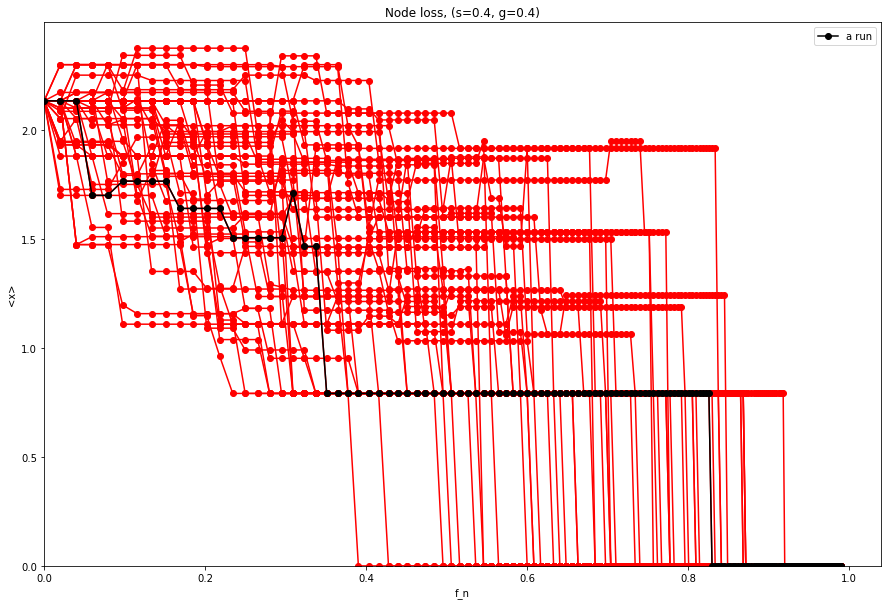

In [12]:
plt.figure(figsize=(15,10))
plt.plot(F_N,activities_nruns.T, 'o-', color='r')
plt.plot(F_N,activities_nruns[np.random.choice(range(nruns),1)[0]], 'o-', color='black', label='a run')

plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.xlabel(f'f_n')
plt.ylabel(f'<x>')
plt.title(f'Node loss, (s={s}, g={g})')
plt.legend()

plt.show()